# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [1]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

In [2]:
print(type(newsgroupsdocs))
print(len(newsgroupsdocs))

<class 'list'>
18846


Utilizaremos tan solo la mitad debido a que la RAM se dispara al ocupar todo.

In [3]:
corpus = newsgroupsdocs[:int(len(newsgroupsdocs)/2)]

In [4]:
len(corpus)

9423

### Limpieza del texto

Primero nos encargamos de los caracteres raros.

In [5]:
import re

def clean_text(text):
    text = text.replace('\n', ' ').replace('\t', ' ').replace(".", " ").replace(",", " ").replace("/", " ")
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # Remove special characters and punctuation
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space
    return text.strip().lower()

corpus = [clean_text(text) for text in corpus]

In [7]:
len(corpus)

9423

Quitamos los documentos vacíos.

In [8]:
corpus = list(filter(lambda doc: doc and doc.strip(), corpus))

In [9]:
len(corpus)

9155

Todas las palabras deben ser capturadas en una lista.

In [10]:
words = set(" ".join(corpus).lower().split())

In [11]:
len(words)

84876

Ahora, utilizamos el Stemming para disminuir el tamaño de espacio de palabras. El Stemming vuelve a palabras complejas a su forma original o inicial.

In [12]:
from nltk.stem import porter
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
words = set([stemmer.stem(word) for word in words])

In [13]:
len(words)

69034

Finalmente, realizamos una limpieza de palabras que no aportan valor.

In [14]:
def is_valid_word(token):
  if len(token) < 2 or len(token) > 25:
      return False

  if sum(c.isdigit() for c in token) > len(token) / 2:
      return False

  if re.search(r'[a-zA-Z]\d[a-zA-Z]', token):
      return False

  return True

words = [word for word in words if is_valid_word(word)]

In [15]:
len(words)

54438

Construimos una función para normalizar las palabras en base a los pasos anteriormente tomados.

In [29]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

def get_tokens(doc):
    cleaned_doc = clean_text(doc)

    tokens = word_tokenize(cleaned_doc)

    processed_tokens = []
    for token in tokens:
        stemmed_token = stemmer.stem(token)
        if is_valid_word(stemmed_token):
            processed_tokens.append(stemmed_token)

    return processed_tokens

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

### Cálculo de TF-IDF de manera manual

Primero obtenemos TF de cada documento.

In [24]:
from collections import Counter
import numpy as np

def get_tf(doc, vocab_index):
  words = get_tokens(doc)
  total = len(words)
  counts = Counter(words)
  tf = np.zeros(len(vocab_index))

  if total == 0:
    return tf

  keys = vocab_index.keys()

  for word, count in counts.items():
    if word in keys:
      tf[vocab_index[word]] = count / total
  return np.array(tf)

Después IDF.

In [25]:
def get_idf(corpus, vocab_index):
  n_docs = len(corpus)
  df = np.zeros(len(vocab_index))

  for doc in corpus:
    words = get_tokens(doc.lower().split())
    for w in words:
      if w in vocab_index:
        df[vocab_index[w]] += 1
  idf = np.log((n_docs + 1) / (df + 1)) + 1
  return idf

Finalmente TF-IDF.

In [19]:
def get_tf_idf(tf, idf):
  return tf * idf

Ahora calculamos las matrices para nuestro corpus. Utilizamos un índice para disminuir el costo computacional.

In [ ]:
vocab_index = {word: index for index, word in enumerate(words)}

In [ ]:
tf = np.array([get_tf(doc, vocab_index) for doc in corpus])

In [ ]:
idf = get_idf(corpus, vocab_index)

In [ ]:
tf_idf = get_tf_idf(tf, idf)

In [ ]:
tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Construimos un diccionario para visualizar los datos mediante la librería pandas.

In [ ]:
import pandas as pd

df = pd.DataFrame(tf_idf, columns=words)

In [ ]:
df

,kale,canadian,31st,puncher,discount,aswel,roenick,fcp,difo,nahum,...,shanley,parliamentarian,knive,kefalonia,fulton,turmoil,fuch,venu,realism,dracula
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cálculo de TF-IDF usando sklearn

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizador = TfidfVectorizer(tokenizer=get_tokens)

tf_idf = vectorizador.fit_transform(corpus)
terminos = vectorizador.get_feature_names_out()

df = pd.DataFrame(tf_idf.todense(), columns=terminos)
df

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,000mile,000usd,00acearl,00each,00index,00lb,00mhz,00pm,00tx,00tzxb,...,zzc6,zzi,zzneu,zznki,zznkzz,zznp,zzrk,zzzoh,zzzzzz,zzzzzzt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def rank_documents(query, tfidf_matrix, vectorizer, corpus):
  # query
  query_vector = vectorizer.transform([query])

  # coseno
  cosine_sim = cosine_similarity(query_vector, tfidf_matrix).flatten()

  ranking = np.argsort(-cosine_sim)

  results = pd.DataFrame({
    'Documento': [corpus[i] for i in ranking],
    'Similaridad': cosine_sim[ranking]
  })

  return results


In [22]:
query = "vegetarian onion diet"
results_df = rank_documents(query, tf_idf, vectorizador, corpus)

print("TF-IDF rank del query:", query)
print(results_df)

TF-IDF rank del query: vegetarian onion diet
                                              Documento  Similaridad
0                         yup with onions of all things     0.443322
1     Not sure of this but I think some millipedes c...     0.210024
2     Millipedes I understand are vegetarian and the...     0.183689
3     Non smoking roommate needed to sublet 1BR in 2...     0.138273
4     As I understood it MSG is natural Isn t it fou...     0.121792
...                                                 ...          ...
9150  I some years ago almost became a victim of thi...     0.000000
9151  Many thanks to those who replied to my appeal ...     0.000000
9152  The willingness of the majority of the people ...     0.000000
9153  There are two simple procedures for alterating...     0.000000
9154  I am sure some bashers of Pens fans are pretty...     0.000000

[9155 rows x 2 columns]


## Parte 3: Ranking con BM25

### Actividad

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

Hay demasiadas variables, por lo tanto, declararemos variables globales de la siguiente manera:

In [43]:
N = 0          # Número total de documentos
DOC_LENGTHS = []    # Longitudes de los documentos tokenizados
AVG_DL = 0             # Longitud promedio de los documentos
IDF_DICT = {}         # Diccionario de valores IDF
TF_MATRIX = []      # Lista de diccionarios de frecuencia de términos (TF) por documento
TOKENIZED_COLLECTION = [] # Documentos limpios y tokenizados
DOC_COLLECTION = []    # Documentos originales

Aquí necesitamos el promedio de la longitud de documentos para normalizarlos. De igual manera con idf.

In [49]:
def calculate_collection_stats(documents):
  global N, DOC_LENGTHS, AVG_DL, DOC_COLLECTION, TOKENIZED_COLLECTION

  DOC_COLLECTION = documents
  N = len(documents)

  TOKENIZED_COLLECTION = [get_tokens(doc) for doc in documents]

  DOC_LENGTHS = [len(tokens) for tokens in TOKENIZED_COLLECTION]

  if N > 0:
    AVG_DL = np.mean(DOC_LENGTHS)
  else:
    AVG_DL = 0

Reescribimos la función de tf pero sin dividirlo por el total de términos por documento.

In [50]:
import math
from collections import defaultdict

def calculate_tf_and_df():
  global TF_MATRIX
  doc_freqs = defaultdict(int)

  for tokens in TOKENIZED_COLLECTION:
    TF_MATRIX.append(Counter(tokens))

    for term in set(tokens):
      doc_freqs[term] += 1

  return doc_freqs

def calculate_idf(doc_freqs):
  global IDF_DICT
  IDF_DICT = {}

  for term, n_q in doc_freqs.items():
    idf = math.log((N - n_q + 0.5) / (n_q + 0.5) + 1)
    IDF_DICT[term] = idf

Ahora podemos probarlas.

In [46]:
calculate_collection_stats(corpus)
print(f"{AVG_DL:.2f}")

182.91


In [47]:
doc_freqs = calculate_tf_and_df()
print(doc_freqs)

defaultdict(<class 'int'>, {'lot': 687, 'prais': 22, 'in': 5885, 'disappoint': 23, 'howev': 651, 'relief': 34, 'ani': 2430, 'pittsburgh': 72, 'fun': 103, 'recent': 379, 'jersey': 47, 'and': 6510, 'lose': 149, 'should': 1239, 'season': 166, 'anyway': 340, 'end': 574, 'coupl': 303, 'reliev': 24, 'than': 1665, 'non': 445, 'massacr': 76, 'have': 4540, 'confus': 136, 'about': 2511, 'better': 732, 'puzzl': 30, 'final': 335, 'out': 2086, 'jagr': 18, 'bit': 604, 'those': 1020, 'just': 2059, 'go': 1388, 'also': 1629, 'was': 2813, 'they': 2760, 'man': 378, 'beat': 109, 'kill': 369, 'veri': 1259, 'pretti': 378, 'you': 4169, 'his': 1079, 'actual': 703, 'see': 1246, 'stat': 72, 'basher': 8, 'thought': 471, 'for': 5203, 'show': 547, 'post': 980, 'game': 479, 'devil': 61, 'put': 673, 'kind': 492, 'much': 1214, 'am': 1242, 'the': 7875, 'watch': 232, 'is': 5831, 'an': 2845, 'sure': 770, 'some': 2158, 'sinc': 911, 'wors': 145, 'too': 962, 'fo': 10, 'whi': 966, 'bowman': 7, 'not': 3889, 'playoff': 92, 't

In [48]:
calculate_idf(doc_freqs)

Con esto, podemos hacer una función para calcular el score y ordenarlos al hacer una consulta.

In [54]:
def calculate_bm25_score(term_freq, doc_len, idf,avgdl, k1=1.2, b=0.75):
  # Score = IDF * [ (f(q,D) * (k1 + 1)) / (f(q,D) + k1 * (1 - b + b * (|D|/avgdl))) ]
  if idf == 0 or term_freq == 0:
    return 0.0

  # Normalizacion longitud (RLV)
  rlv_component = k1 * ((1 - b) + b * (doc_len / avgdl))

  numerator = term_freq * (k1 + 1)
  denominator = term_freq + rlv_component

  return idf * (numerator / denominator)

In [55]:
def search_bm25(query, top_k=5):
    if not IDF_DICT:
        print("Cree BM25")
        return []

    query_tokens = get_tokens(query)
    doc_scores = defaultdict(float)

    for i in range(N):
        doc_len = DOC_LENGTHS[i]
        tf = TF_MATRIX[i]
        score = 0.0

        for term in query_tokens:
            # si no existe, son 0.
            idf = IDF_DICT.get(term, 0)
            term_freq = tf.get(term, 0)

            score += calculate_bm25_score(term_freq, doc_len, idf, AVG_DL)

        doc_scores[i] = score

    sorted_scores = sorted(doc_scores.items(), key=lambda item: item[1], reverse=True)

    results = []
    for doc_index, score in sorted_scores[:top_k]:
        if score > 0:
            results.append({
                'score': score,
                'document': DOC_COLLECTION[doc_index],
                'index': doc_index
            })

    return results

Podemos hacer una consulta con la última función de la siguiente manera:

In [56]:
query = "bad and good"
results = search_bm25(query, top_k=3)

for result in results:
    print(f"Puntuación: {result['score']:.4f}")
    print(f"Documento (Índice {result['index']}): {result['document']}\n")

Puntuación: 8.1804
Documento (Índice 7396): I am very serious about the purchase of a 486dx 33 that uses the Orchid VLB mother board The system also has the VLB IDE and Fahrenheit video board in it I haven t seen or heard ANY bad comments about this board Does anyone out there have any comments good or bad about this board I am considering this board primarily because of Orchid s reputation and long standing in the field Thanks for any and all comments

Puntuación: 8.1387
Documento (Índice 7673): Any comments of AMD microprocessors good bad

Puntuación: 8.0761
Documento (Índice 1217): I don t know why it is so obvious We are not speaking of acts of the flesh We are just speaking of emotions Emotions are not of themselves moral or immoral good or bad Emotions just are The first step is not to label his emotion as good or bad or to numb ourselves so that we hide our true feelings it is to accept ourselves as we are as God accepts us It seems that Paul s anger he has accepted and channele

In [57]:
print("Resultados BM25")
for result in results:
    print(f"Puntuación: {result['score']:.4f}")
    print(f"Documento (Índice {result['index']}): {result['document']}\n")

Resultados BM25
Puntuación: 8.1804
Documento (Índice 7396): I am very serious about the purchase of a 486dx 33 that uses the Orchid VLB mother board The system also has the VLB IDE and Fahrenheit video board in it I haven t seen or heard ANY bad comments about this board Does anyone out there have any comments good or bad about this board I am considering this board primarily because of Orchid s reputation and long standing in the field Thanks for any and all comments

Puntuación: 8.1387
Documento (Índice 7673): Any comments of AMD microprocessors good bad

Puntuación: 8.0761
Documento (Índice 1217): I don t know why it is so obvious We are not speaking of acts of the flesh We are just speaking of emotions Emotions are not of themselves moral or immoral good or bad Emotions just are The first step is not to label his emotion as good or bad or to numb ourselves so that we hide our true feelings it is to accept ourselves as we are as God accepts us It seems that Paul s anger he has accep

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

Vamos a realizar la misma query. Y consultar a los dos modelos.

In [58]:
query = "bad and good"

In [59]:
results_bm25 = search_bm25(query, top_k=3)
print("Resultados BM25")
for result in results_bm25:
    print(f"Puntuación: {result['score']:.4f}")
    print(f"Documento (Índice {result['index']}): {result['document']}\n")

Resultados BM25
Puntuación: 8.1804
Documento (Índice 7396): I am very serious about the purchase of a 486dx 33 that uses the Orchid VLB mother board The system also has the VLB IDE and Fahrenheit video board in it I haven t seen or heard ANY bad comments about this board Does anyone out there have any comments good or bad about this board I am considering this board primarily because of Orchid s reputation and long standing in the field Thanks for any and all comments

Puntuación: 8.1387
Documento (Índice 7673): Any comments of AMD microprocessors good bad

Puntuación: 8.0761
Documento (Índice 1217): I don t know why it is so obvious We are not speaking of acts of the flesh We are just speaking of emotions Emotions are not of themselves moral or immoral good or bad Emotions just are The first step is not to label his emotion as good or bad or to numb ourselves so that we hide our true feelings it is to accept ourselves as we are as God accepts us It seems that Paul s anger he has accep

In [60]:
results_df = rank_documents(query, tf_idf, vectorizador, corpus)

print("TF-IDF rank del query:", query)
print(results_df)

TF-IDF rank del query: bad and good
                                              Documento  Similaridad
0                                             very good     0.402075
1          Any comments of AMD microprocessors good bad     0.365753
2                                             Good luck     0.275191
3     does anyone have any good code to drive the se...     0.261241
4     You ll have to kill off half the net Maybe tha...     0.238568
...                                                 ...          ...
9150  While driving through the middle of nowhere I ...     0.000000
9151  The newest JDR Microdevices catalog has at lea...     0.000000
9152  My brother is in the market for a high perform...     0.000000
9153                                        Bo Bilinsky     0.000000
9154  Sorry Mike What defensemen would the Wings be ...     0.000000

[9155 rows x 2 columns]


In [61]:
bm25_data = {
    '7396': 8.1804,
    '7673': 8.1387,
    '1217': 8.0761
}

tfidf_data = {
    '7396': 0.402075,
    '7673': 0.365753, # Este índice parece ser el mismo que el segundo de tu output TF-IDF
    '1217': 0.275191
}

In [62]:
df_comparison = pd.DataFrame({
    'BM25': pd.Series(bm25_data),
    'TF-IDF': pd.Series(tfidf_data)
})

# Reordenar y limpiar
df_comparison.index.name = 'Índice del Documento'
df_comparison.sort_values(by='BM25', ascending=False, inplace=True)

# Muestra el DataFrame para verificar los datos antes de graficar
print("DataFrame de Comparación:")
print(df_comparison)

DataFrame de Comparación:
                        BM25    TF-IDF
Índice del Documento                  
7396                  8.1804  0.402075
7673                  8.1387  0.365753
1217                  8.0761  0.275191


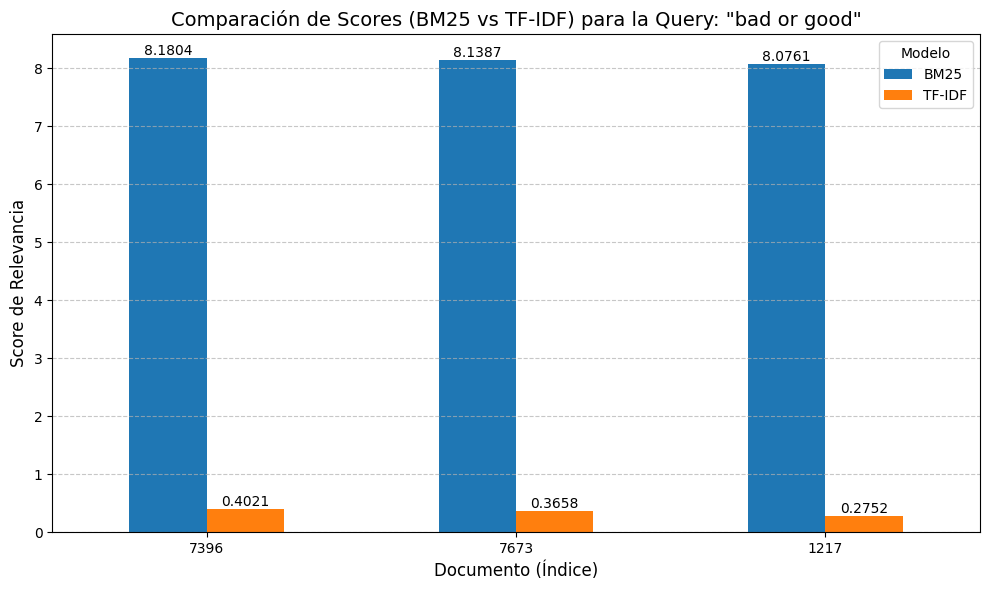

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

df_comparison.plot.bar(ax=ax, rot=0)

ax.set_title(f'Comparación de Scores (BM25 vs TF-IDF) para la Query: "bad or good"', fontsize=14)
ax.set_xlabel('Documento (Índice)', fontsize=12)
ax.set_ylabel('Score de Relevancia', fontsize=12)
ax.legend(title='Modelo')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

plt.tight_layout()
plt.show()

Los valores son muy diferentes debido a como abordan la similitud de la query con los documentos. En TF-IDF, utilizamos coseno para comprobarlo y generar un ranking, mientras que en BM25 realizamos una suma de términos agravantes de la query y los documentos.

## Parte 5: Evaluación con consulta relevante

### Actividad

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [65]:
relevantQueries = {
  "bad or good": [7673, 7396, 1217, 9811],
  "AMD microprocessor review": [7673, 812, 110, 999],
  "high performance computing": [5401, 5402, 5403]
}

In [78]:
def calculatePrecisionAtK(ranking, relevantIndices, k):
    retrievedIndices = [result['index'] for result in ranking[:k]]

    numRelevantRetrieved = len(set(retrievedIndices) & set(relevantIndices))

    return numRelevantRetrieved / k if k > 0 else 0.0

def calculateAveragePrecision(ranking, relevantIndices):
    numRelevant = len(relevantIndices)
    if numRelevant == 0:
        return 0.0

    sumPrecision = 0.0
    numRelevantFound = 0

    for k, result in enumerate(ranking, 1):
        if result['index'] in relevantIndices:
            numRelevantFound += 1
            precisionAtK = numRelevantFound / k
            sumPrecision += precisionAtK

    return sumPrecision / numRelevant

In [76]:
def evaluateModels(documents, relevantQueries):
    evaluationResults = defaultdict(lambda: defaultdict(float))

    K = 5

    for query, relevantIndices in relevantQueries.items():
        print(f"\n--- Evaluando Query: '{query}' ---")

        bm25Ranking = search_bm25(query, top_k=len(documents))
        tfidfRanking = rank_documents(query, tf_idf, vectorizador, corpus)

        # BM25
        pAtK_bm25 = calculatePrecisionAtK(bm25Ranking, relevantIndices, K)
        ap_bm25 = calculateAveragePrecision(bm25Ranking, relevantIndices)
        evaluationResults['BM25']['P@K'] += pAtK_bm25
        evaluationResults['BM25']['MAP'] += ap_bm25

        # TF-IDF
        pAtK_tfidf = calculatePrecisionAtK(tfidfRanking, relevantIndices, K)
        ap_tfidf = calculateAveragePrecision(tfidfRanking, relevantIndices)
        evaluationResults['TF-IDF']['P@K'] += pAtK_tfidf
        evaluationResults['TF-IDF']['MAP'] += ap_tfidf

        print(f"P@{K} BM25: {pAtK_bm25:.4f} | AP BM25: {ap_bm25:.4f}")
        print(f"P@{K} TF-IDF: {pAtK_tfidf:.4f} | AP TF-IDF: {ap_tfidf:.4f}")

    # - MAP
    numQueries = len(relevantQueries)

    # Promediar P@K
    meanResults = {
        'BM25': {
            f'MP@{K}': evaluationResults['BM25']['P@K'] / numQueries,
            'MAP': evaluationResults['BM25']['MAP'] / numQueries
        },
        'TF-IDF': {
            f'MP@{K}': evaluationResults['TF-IDF']['P@K'] / numQueries,
            'MAP': evaluationResults['TF-IDF']['MAP'] / numQueries
        }
    }

    return meanResults